In [3]:
# Imports 

import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Image processing
import cv2

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Evaluation

Displaying row 1


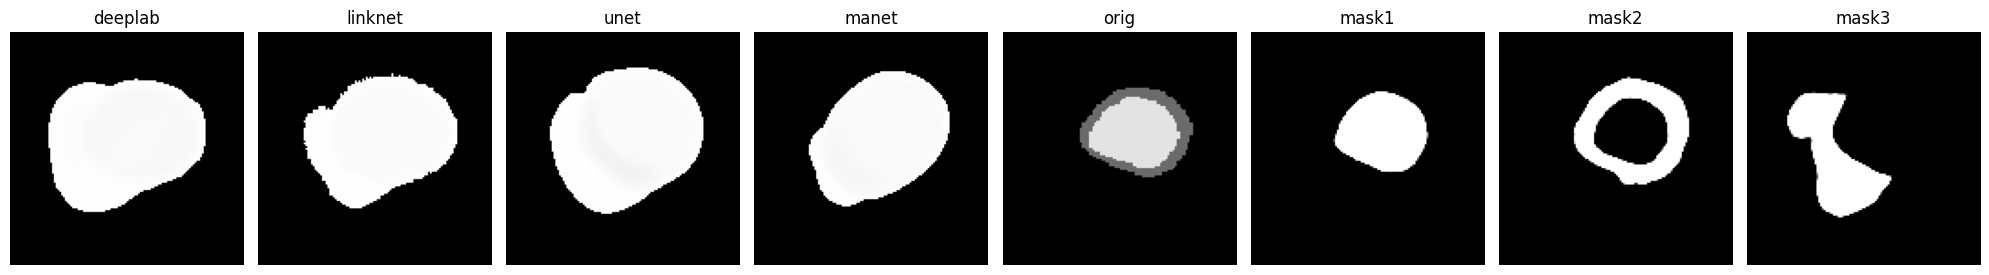

Displaying row 2


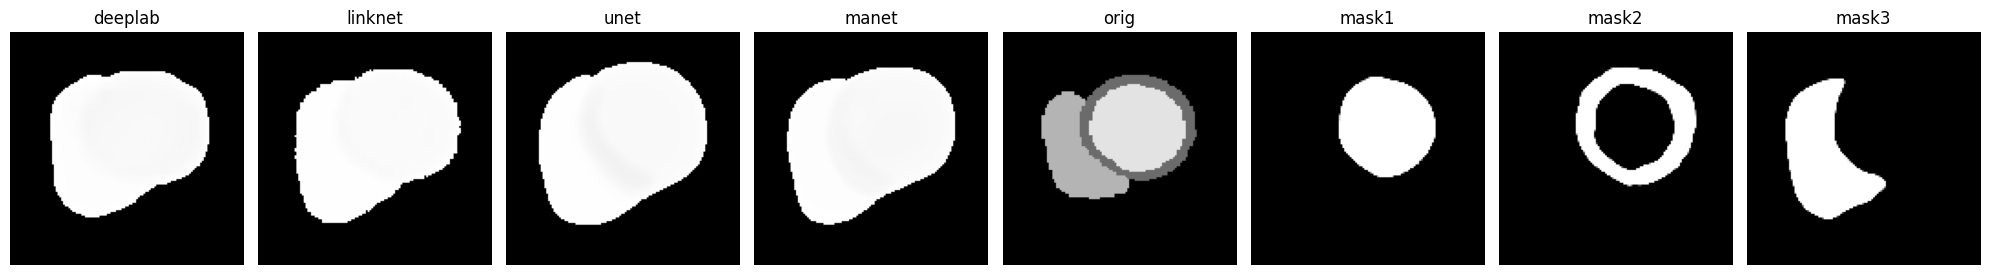

Displaying row 3


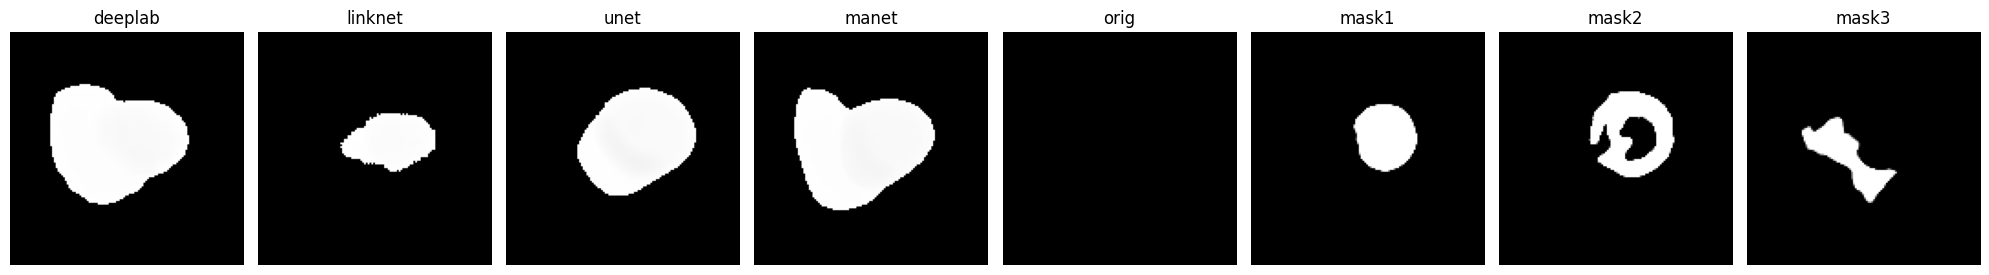

Displaying row 4


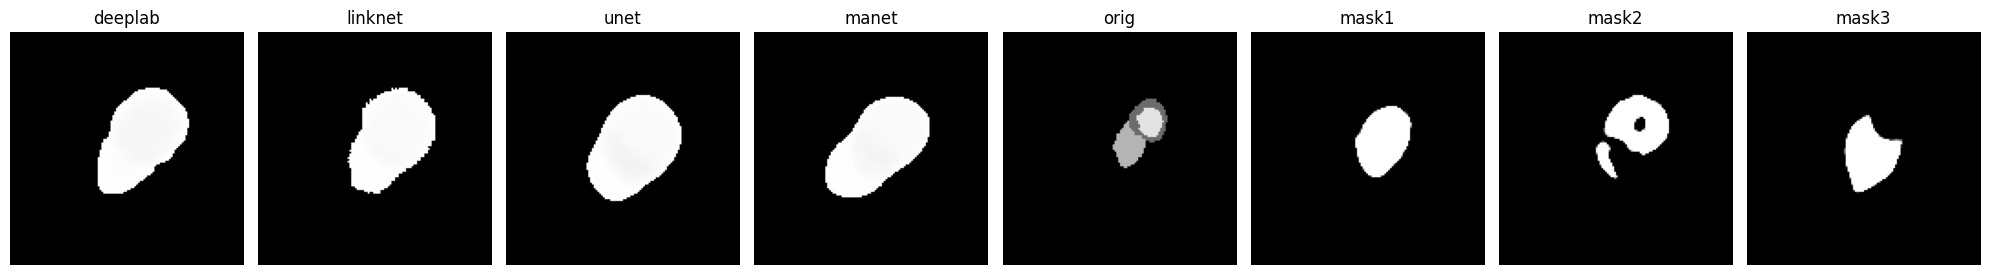

Displaying row 5


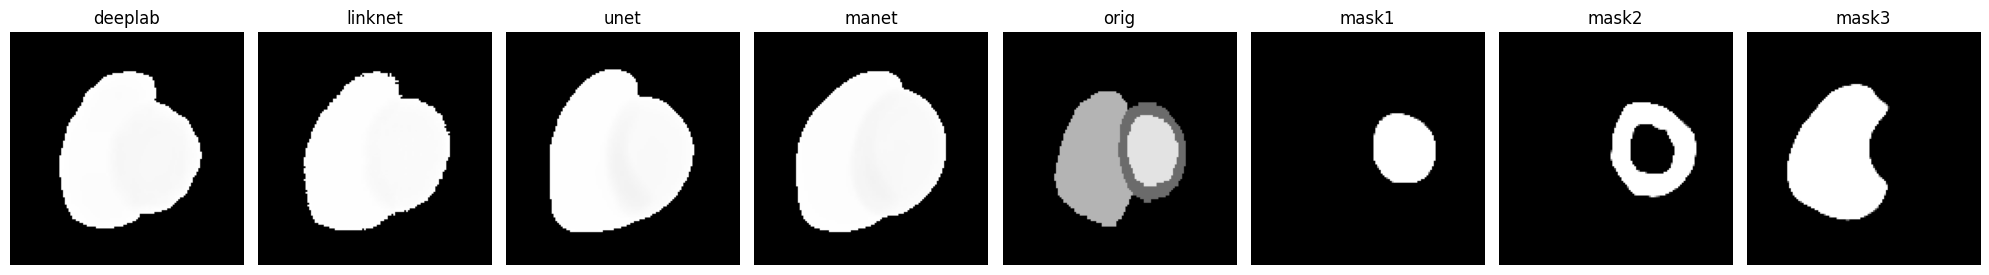

In [4]:


# -------------------------------
# Load CSV Data
# -------------------------------

csv_path = 'D:/deep_larning/output_img.csv'
df = pd.read_csv(csv_path)

def show_images_from_row(row, titles):
    """
    Displays images from a single row of paths in subplots.

    Parameters:
        - row (pd.Series): A single row of the DataFrame containing image paths.
        - titles (list): Titles for each subplot corresponding to the columns.
    """
    num_images = len(row)
    plt.figure(figsize=(20, 5))  # Adjust the figure size as needed

    for idx, img_path in enumerate(row):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img* (1 if idx > 4 else 255), cmap='gray')
        plt.title(titles[idx])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

titles = df.columns.tolist()
for i in range(5):
    print(f"Displaying row {i + 1}")
    show_images_from_row(df.iloc[i], titles)


## Thresholding based on F1 score

Average Best Thresholds for Each Image Type (excluding 'orig'):

deeplab: 5.31

linknet: 3.33

unet: 6.87

manet: 5.36

mask1: 156.86

mask2: 253.20

In [6]:
def calculate_precision_recall_f1_accuracy_multi_class(y_true, y_pred, num_classes=3):
    """
    Calculates precision, recall, F1 score, and accuracy for multi-class segmentation.

    Parameters:
        - y_true (np.array): Ground truth segmentation mask with multi-class values.
        - y_pred (np.array): Predicted segmentation mask with multi-class values.
        - num_classes (int): The number of classes (including background).

    Returns:
        - precision (float): Precision score (macro-average).
        - recall (float): Recall score (macro-average).
        - f1 (float): F1 score (macro-average).
        - accuracy (float): Accuracy score (macro-average).
    """
    precision_values = []
    recall_values = []
    f1_values = []
    accuracy_values = []

    for class_id in range(num_classes):
        # Create binary masks for each class
        y_true_bin = (y_true == class_id).astype(int)
        y_pred_bin = (y_pred == class_id).astype(int)

        # Calculate precision, recall, F1, and accuracy for each class
        precision = precision_score(y_true_bin.flatten(), y_pred_bin.flatten())
        recall = recall_score(y_true_bin.flatten(), y_pred_bin.flatten())
        f1 = f1_score(y_true_bin.flatten(), y_pred_bin.flatten())
        accuracy = accuracy_score(y_true_bin.flatten(), y_pred_bin.flatten())

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)
        accuracy_values.append(accuracy)

    # Return macro-average of precision, recall, F1, and accuracy
    return np.mean(precision_values), np.mean(recall_values), np.mean(f1_values), np.mean(accuracy_values)

# -------------------------------
# Function to Perform Thresholding and Metric Calculation
# -------------------------------

def show_best_threshold_from_row(row, titles, best_thresholds_list):
    """
    Displays the thresholded images and their corresponding precision, recall, F1 scores,
    and accuracy in a structured row of subplots, with the original image at the end.
    Also, gathers the best thresholds for each image type.

    Parameters:
        - row (pd.Series): A single row of the DataFrame containing image paths.
        - titles (list): Titles for each subplot corresponding to the columns.
        - best_thresholds_list (list): List to store the best thresholds for all input images.
    """
    num_images = len(row)
    images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in row]
    
    # The 'orig' image is the ground truth (assuming it's the 5th column)
    orig_image = images[4]
    orig_title = titles[4]

    # Titles and images to threshold (excluding the 'orig' image)
    images_to_threshold = images[:4] + images[5:]
    titles_to_threshold = titles[:4] + titles[5:]

    best_thresholds = []
    f1_scores_per_row = []
    accuracy_scores_per_row = []

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))  # Create a row of subplots

    # Perform thresholding for each image individually
    for img_idx, img in enumerate(images_to_threshold):
        min_val, max_val = np.min(img), np.max(img)
        thresholds = np.linspace(min_val, max_val, 100)

        # Arrays to store precision, recall, F1 scores, and accuracy for each threshold
        precision_values = []
        recall_values = []
        f1_values = []
        accuracy_values = []

        # Loop over thresholds
        for threshold in thresholds:
            # Apply thresholding
            _, thresholded_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

            # Calculate precision, recall, F1 score, and accuracy
            precision, recall, f1, accuracy = calculate_precision_recall_f1_accuracy_multi_class(orig_image, thresholded_img)

            precision_values.append(precision)
            recall_values.append(recall)
            f1_values.append(f1)
            accuracy_values.append(accuracy)

        # Find the threshold with the highest F1 score
        best_f1_idx = np.argmax(f1_values)
        best_threshold = thresholds[best_f1_idx]
        best_f1 = f1_values[best_f1_idx]
        best_accuracy = accuracy_values[best_f1_idx]

        # Store the best threshold for plotting
        best_thresholds.append(best_threshold)
        f1_scores_per_row.append(best_f1)
        accuracy_scores_per_row.append(best_accuracy)

        # Apply the best threshold
        _, best_thresholded_img = cv2.threshold(img, best_threshold, 255, cv2.THRESH_BINARY)

        # Plot the thresholded image
        axes[img_idx].imshow(best_thresholded_img, cmap='gray')
        axes[img_idx].set_title(f"{titles_to_threshold[img_idx]}\nF1: {best_f1:.2f}, Accuracy: {best_accuracy:.2f}")
        axes[img_idx].axis('off')

    # Plot the original image at the last position (for comparison)
    axes[-1].imshow(orig_image, cmap='gray')
    axes[-1].set_title(f"{orig_title}")
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

    # Append the best thresholds for this row to the list
    best_thresholds_list.append(best_thresholds)

    return f1_scores_per_row, accuracy_scores_per_row

# -------------------------------
# Function to Calculate Average Best Thresholds, F1 Scores, and Accuracy Scores
# -------------------------------

def calculate_average_best_thresholds_f1_accuracy(best_thresholds_list, all_f1_scores, all_accuracy_scores):
    """
    Calculates the average best threshold for each image type (across all rows),
    and the average F1 score and accuracy score across all rows.

    Parameters:
        - best_thresholds_list (list): A list containing the best thresholds for all rows.
        - all_f1_scores (list): A list containing the best F1 scores for all rows.
        - all_accuracy_scores (list): A list containing the best accuracy scores for all rows.

    Returns:
        - average_best_thresholds (list): The average best thresholds for each image type.
        - average_f1_score (float): The average F1 score across all rows.
        - average_accuracy_score (float): The average accuracy score across all rows.
    """
    # Transpose the list to get best thresholds for each image type (e.g., deeplab, linknet, etc.)
    best_thresholds_array = np.array(best_thresholds_list)
    average_best_thresholds = np.mean(best_thresholds_array, axis=0)

    # Calculate the overall average F1 score and accuracy score across all rows
    average_f1_score = np.mean(all_f1_scores)
    average_accuracy_score = np.mean(all_accuracy_scores)

    return average_best_thresholds, average_f1_score, average_accuracy_score

Displaying thresholded images for row 1


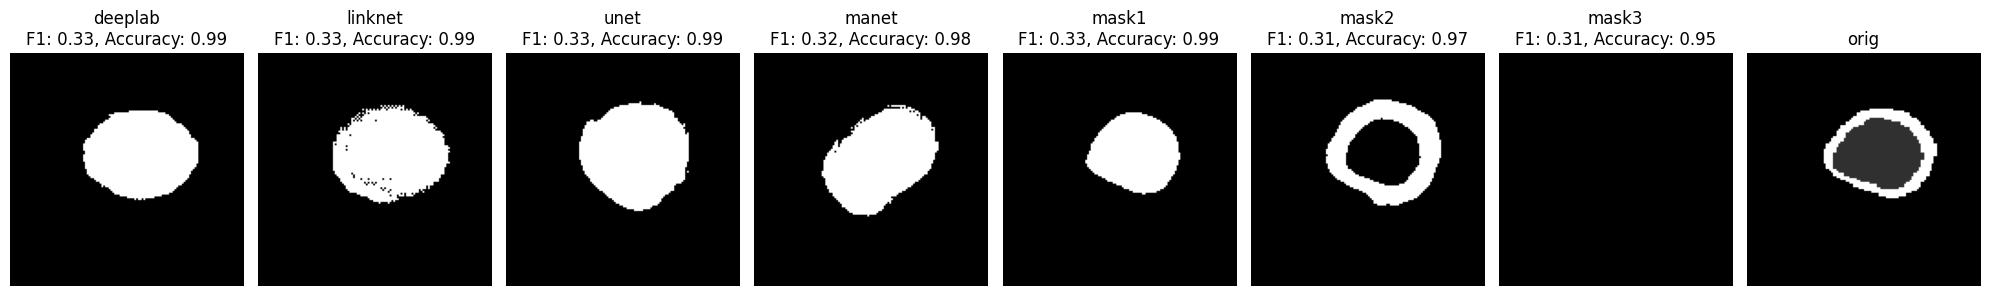

Displaying thresholded images for row 2


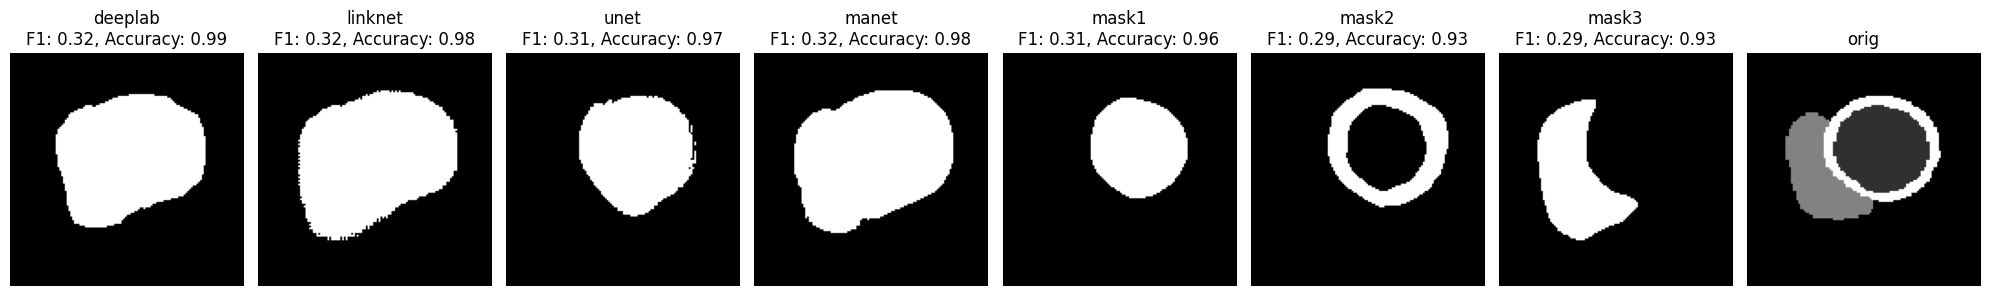

Displaying thresholded images for row 3


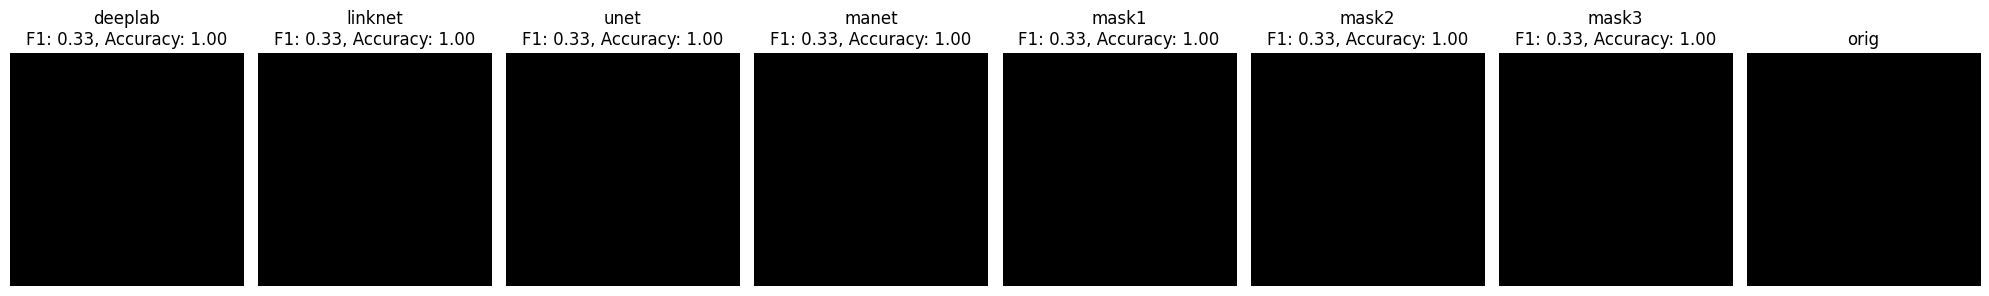

Displaying thresholded images for row 4


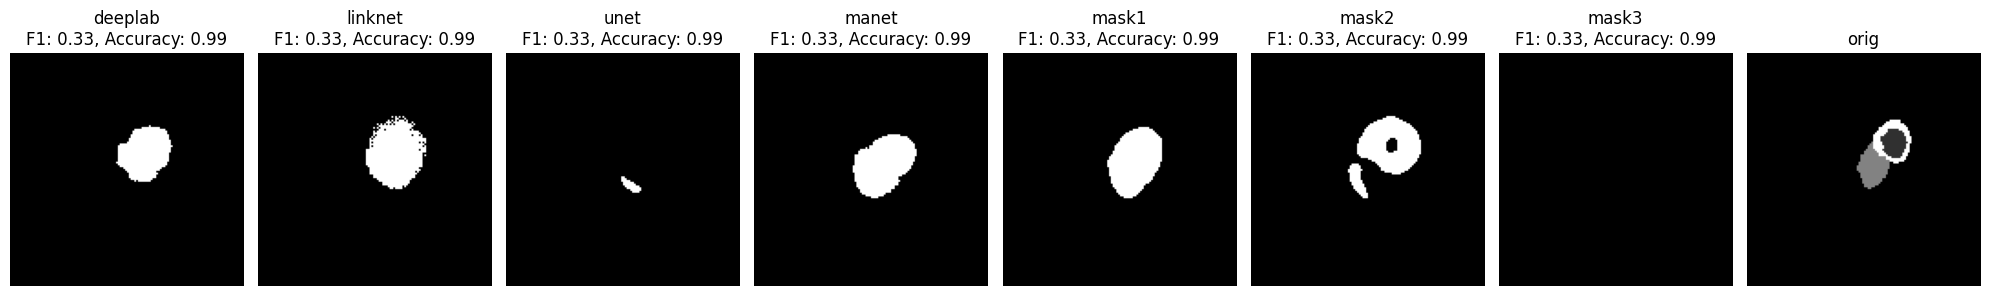

Displaying thresholded images for row 5


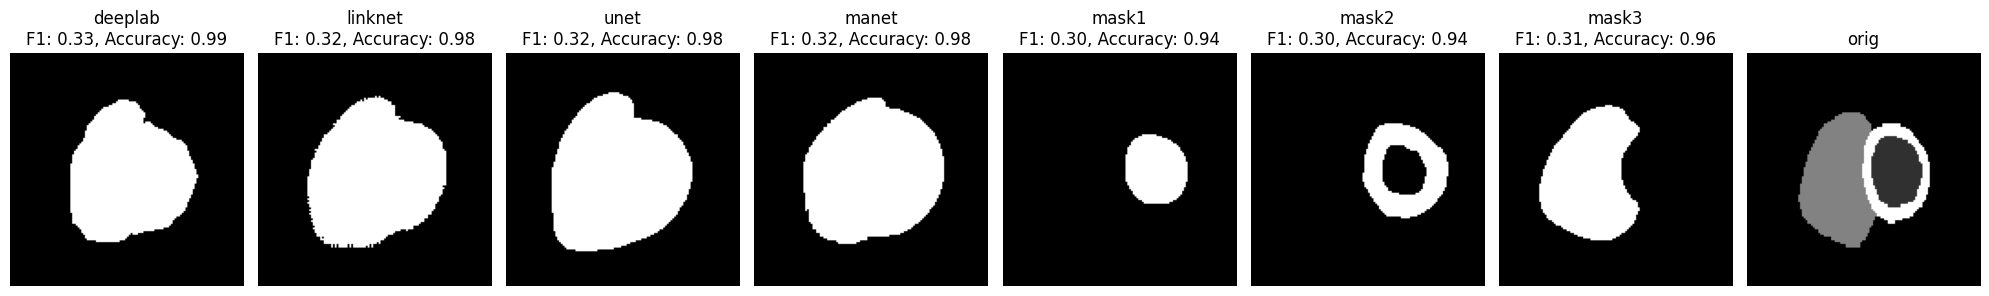

Displaying thresholded images for row 6


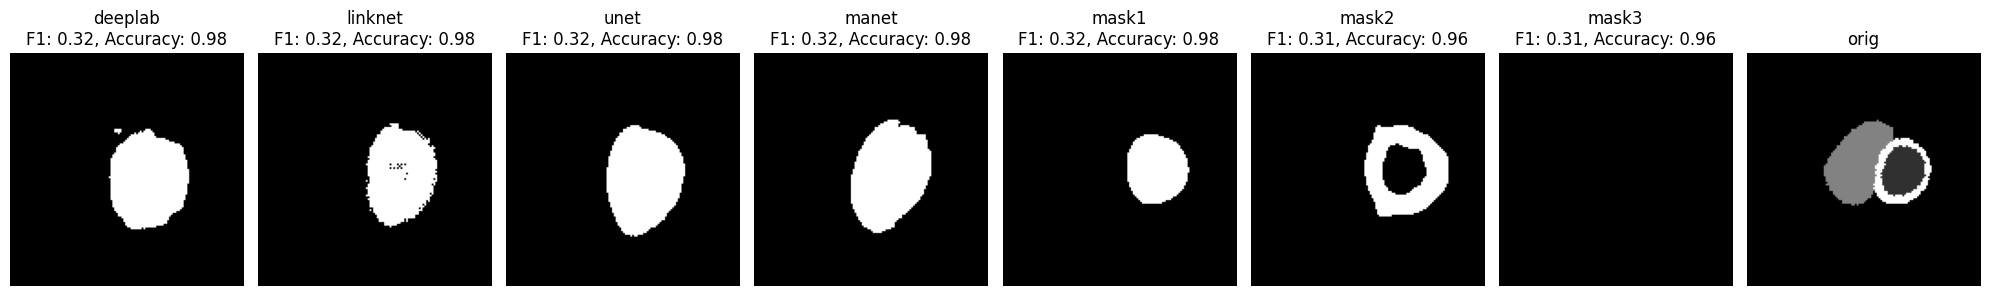

Displaying thresholded images for row 7


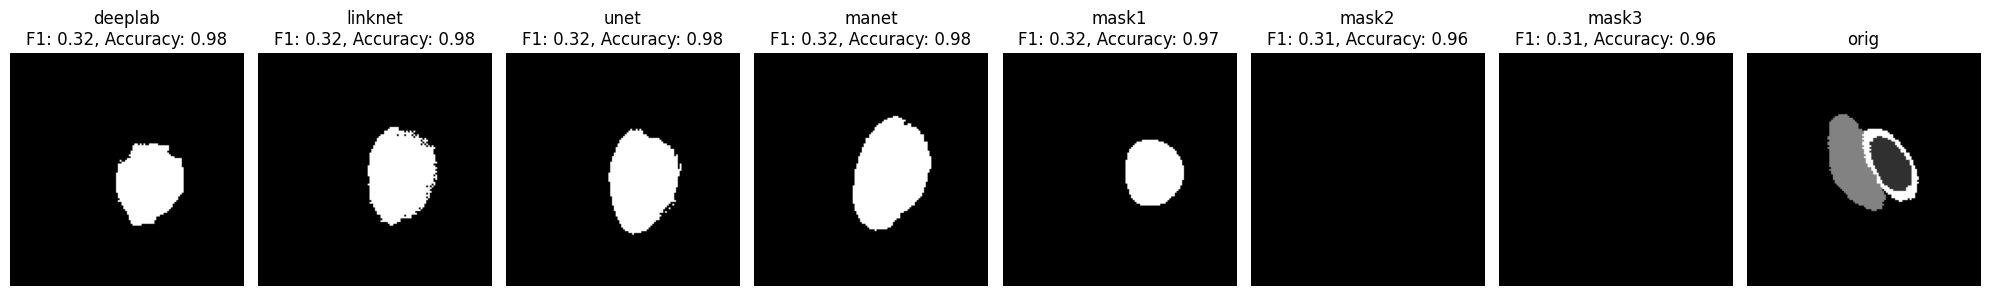

Displaying thresholded images for row 8


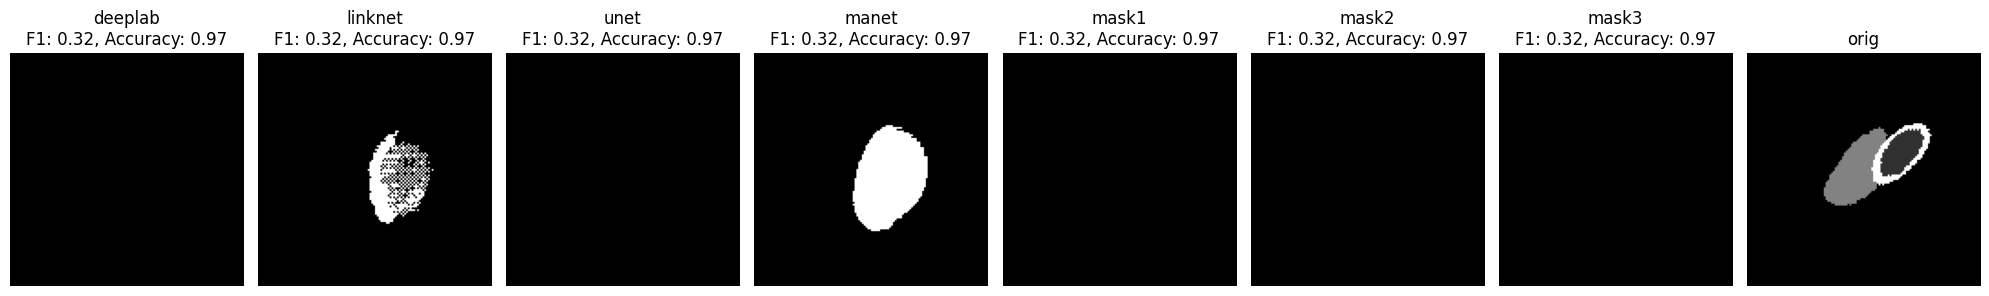

Displaying thresholded images for row 9


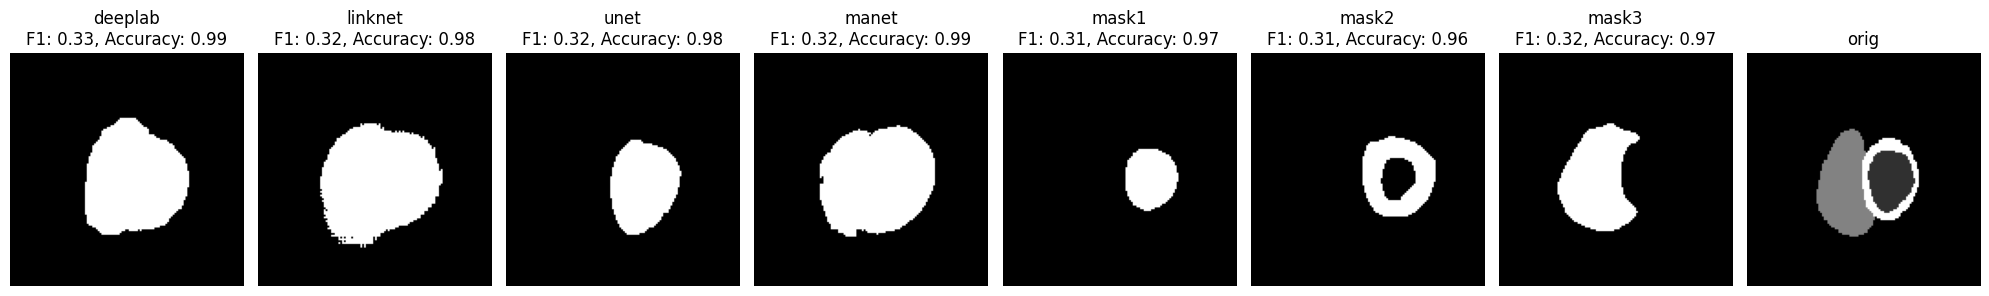

Displaying thresholded images for row 10


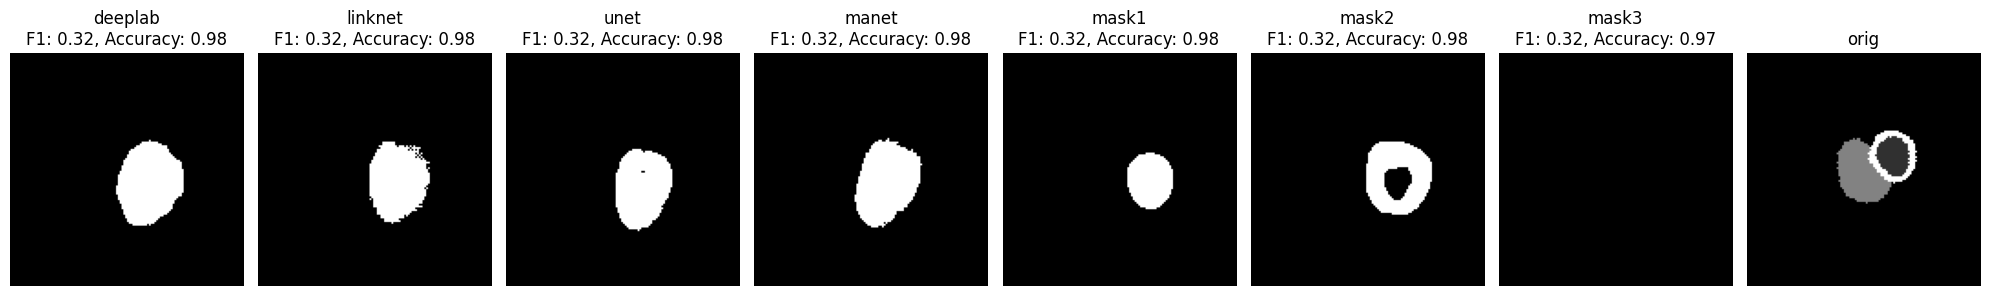


Average Best Thresholds for Each Image Type (excluding 'orig'):
deeplab: 5.31
linknet: 3.33
unet: 6.87
manet: 5.36
mask1: 156.86
mask2: 253.20

Average F1 Score across all rows: 0.32
Average Accuracy Score across all rows: 0.98


In [ ]:
# -------------------------------
# Display Best Thresholded Images for the First Few Rows and Calculate Average Thresholds, F1, and Accuracy
# -------------------------------

titles = df.columns.tolist()

# List to store best thresholds for all rows, F1 scores, and accuracy scores
best_thresholds_list = []
all_f1_scores = []
all_accuracy_scores = []

for i in range(10):  # Display for the first 10 rows
    print(f"Displaying thresholded images for row {i + 1}")
    f1_scores_for_row, accuracy_scores_for_row = show_best_threshold_from_row(df.iloc[i], titles, best_thresholds_list)
    all_f1_scores.extend(f1_scores_for_row)
    all_accuracy_scores.extend(accuracy_scores_for_row)

# Calculate and print the average best thresholds for each image type, the average F1 score, and accuracy score
average_best_thresholds, average_f1_score, average_accuracy_score = calculate_average_best_thresholds_f1_accuracy(
    best_thresholds_list, all_f1_scores, all_accuracy_scores)

print("\nAverage Best Thresholds for Each Image Type (excluding 'orig'):")
for i, avg_threshold in enumerate(average_best_thresholds):
    if titles[i] != "orig":
        print(f"{titles[i]}: {avg_threshold:.2f}")

print(f"\nAverage F1 Score across all rows: {average_f1_score:.2f}")
print(f"Average Accuracy Score across all rows: {average_accuracy_score:.2f}")


## Ensemble model

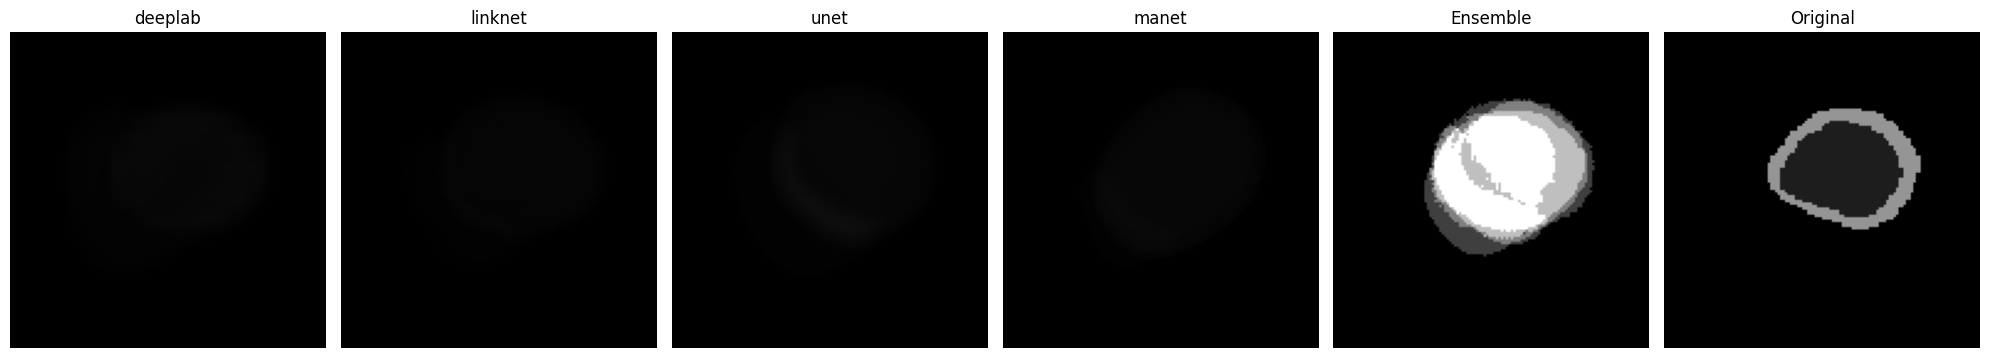

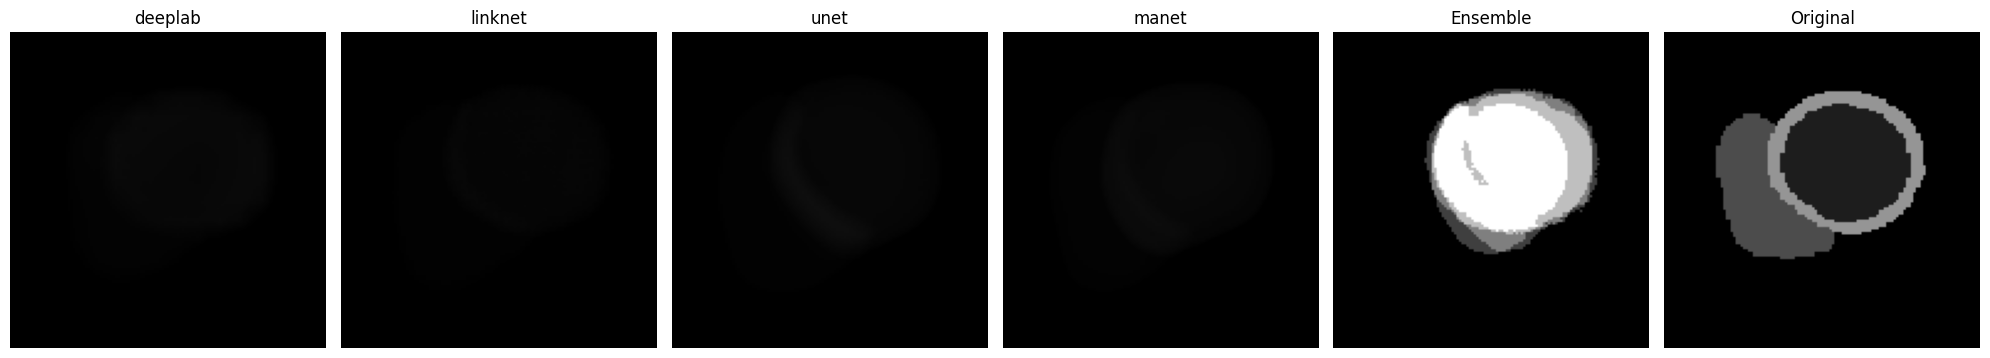

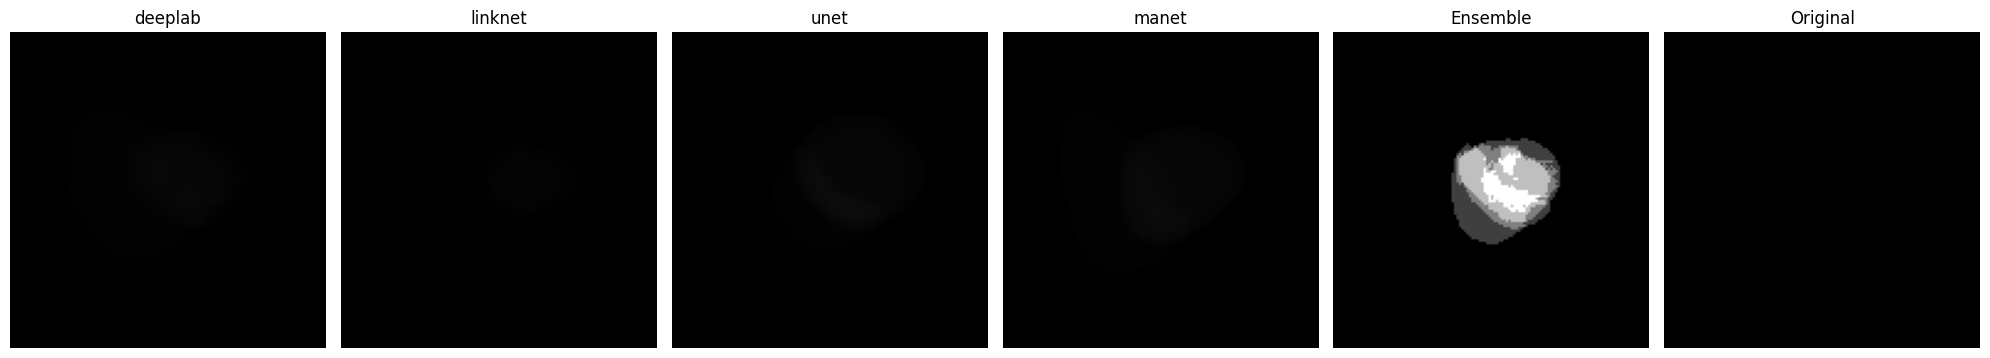

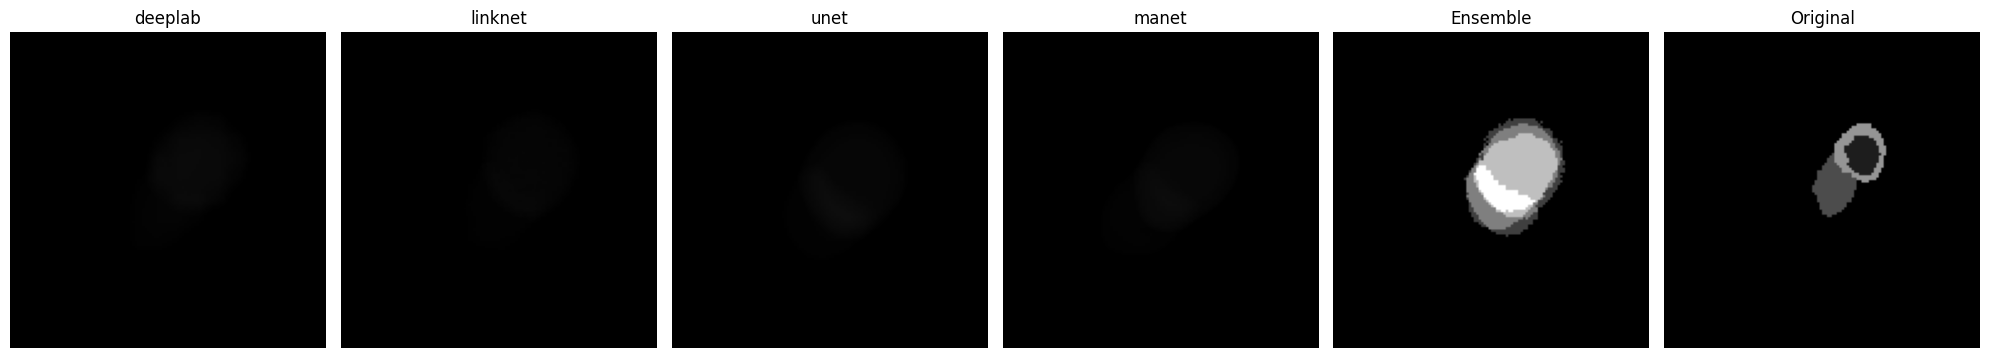

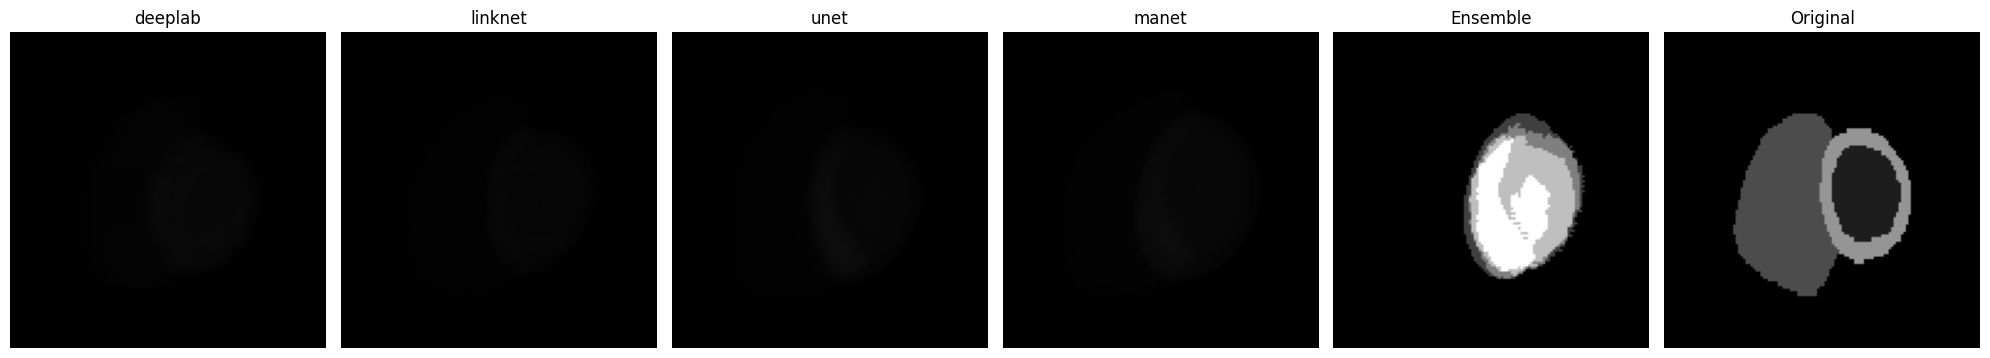

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def ensemble_model_with_thresholds(df, thresholds, method='average'):
    """
    Creates an ensemble of the first 4 models' predictions with given thresholds.
    
    Parameters:
        - df (pd.DataFrame): The dataframe containing paths to model predictions.
        - thresholds (dict): A dictionary containing thresholds for each model.
        - method (str): The method to combine predictions. Options are 'average' or 'vote'.
    
    Returns:
        - None
    """
    model_names = ['deeplab', 'linknet', 'unet', 'manet']  # Model names corresponding to the thresholds
    num_rows = df.shape[0]

    for i in range(num_rows):
        row = df.iloc[i, :4]  # First 4 columns (models' outputs)
        images = []
        predictions = []

        # Load images and apply thresholds to predictions
        for idx, (model_name, img_path) in enumerate(zip(model_names, row)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

            # Apply threshold for the current model
            threshold = thresholds[model_name]
            binary_prediction = (img > threshold).astype(np.float32)
            predictions.append(binary_prediction)

        # Combine the predictions using the chosen method
        if method == 'average':
            ensemble_prediction = np.mean(predictions, axis=0)
        elif method == 'vote':
            # Majority vote for binary predictions
            ensemble_prediction = np.round(np.mean(predictions, axis=0))
        else:
            raise ValueError("Invalid method. Choose 'average' or 'vote'.")

        # Display the images
        titles = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Ensemble', 'Original']
        plt.figure(figsize=(20, 5))

        for idx, img in enumerate(images):
            plt.subplot(1, 6, idx + 1)
            plt.imshow(img)
            plt.title(f'{model_names[idx]}')
            plt.axis('off')
        
        # Display ensemble output
        plt.subplot(1, 6, 5)
        plt.imshow(ensemble_prediction, cmap='gray')
        plt.title('Ensemble')
        plt.axis('off')

        # Display original image
        original_img_path = df.iloc[i, 4]  # Assuming the original image is in the 5th column
        original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 6, 6)
        plt.imshow(original_img)
        plt.title('Original')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

thresholds = {
    'deeplab': 5.31,
    'linknet': 3.33,
    'unet': 6.87,
    'manet': 5.36
}

ensemble_model_with_thresholds(df.head(5), thresholds, method='average')


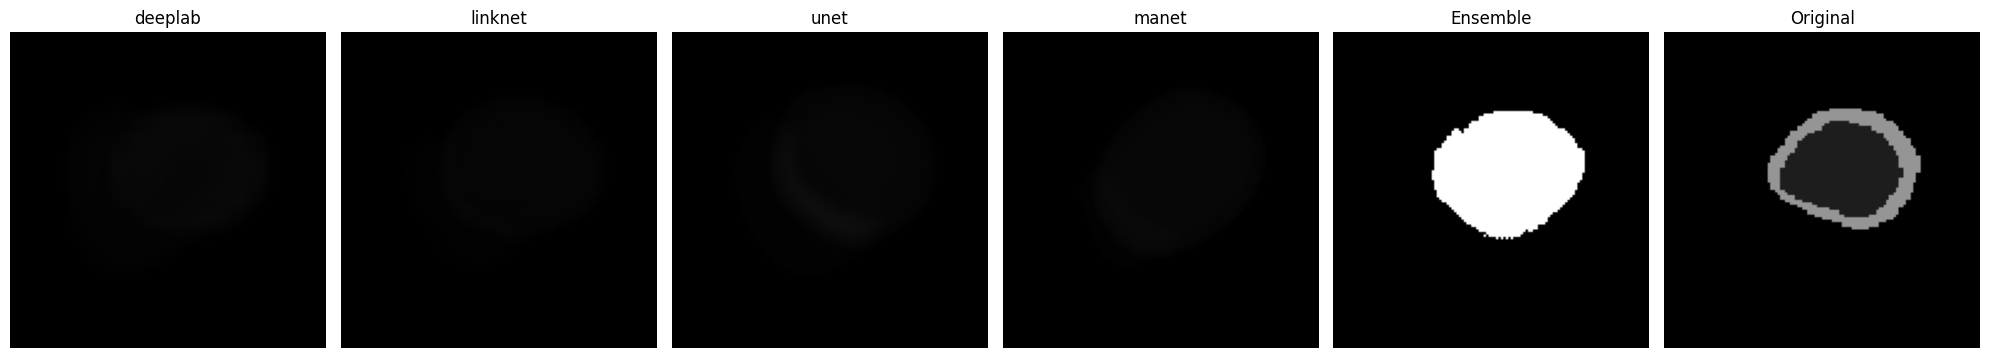

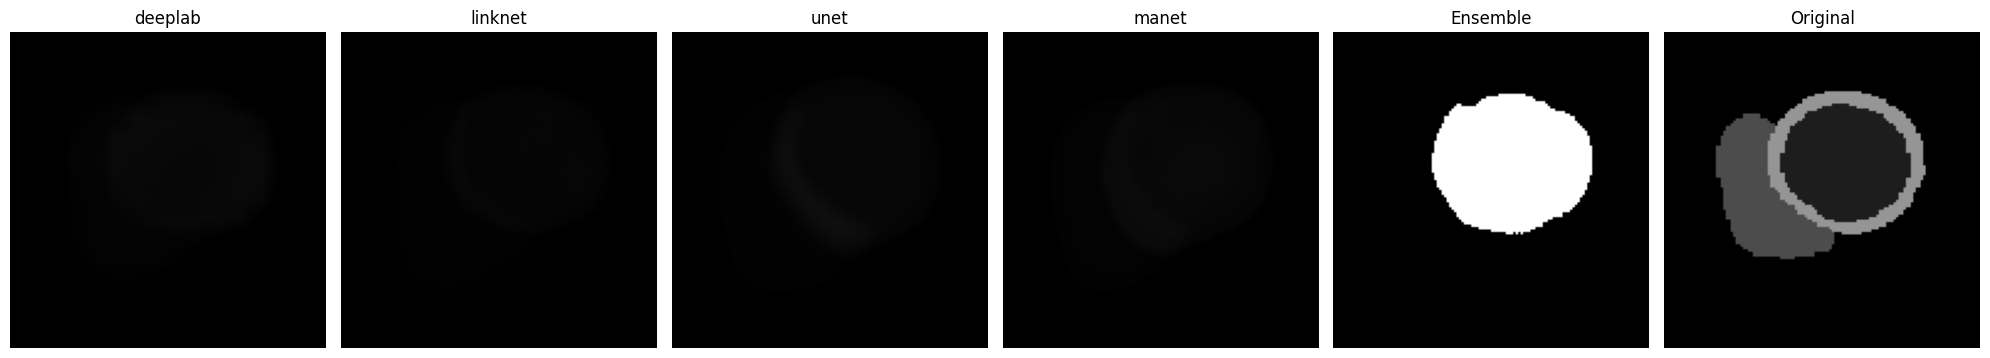

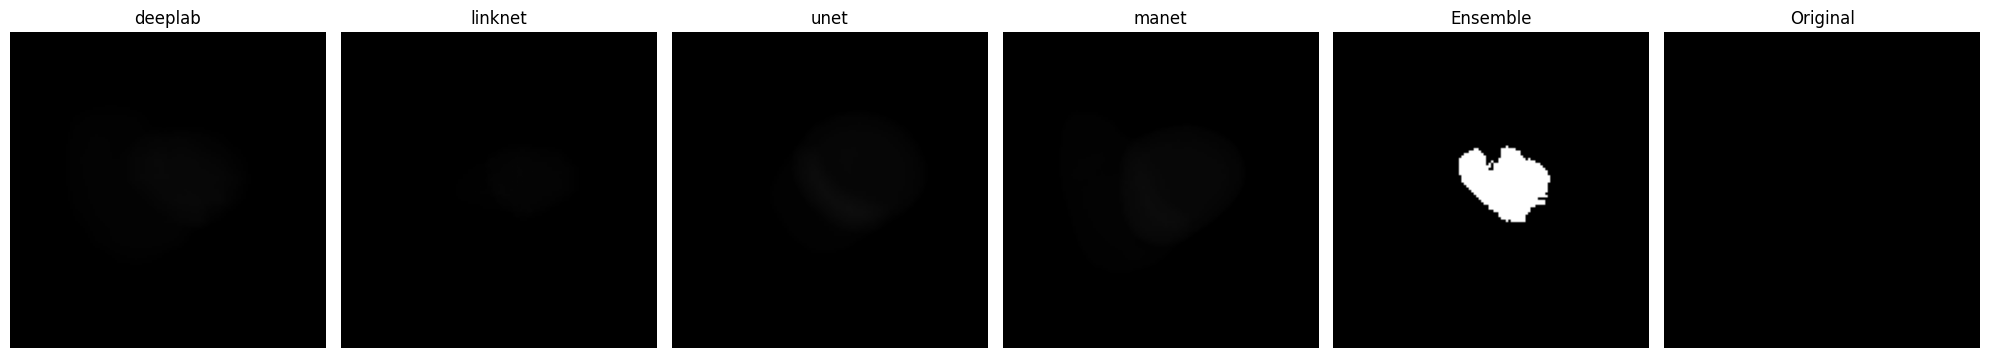

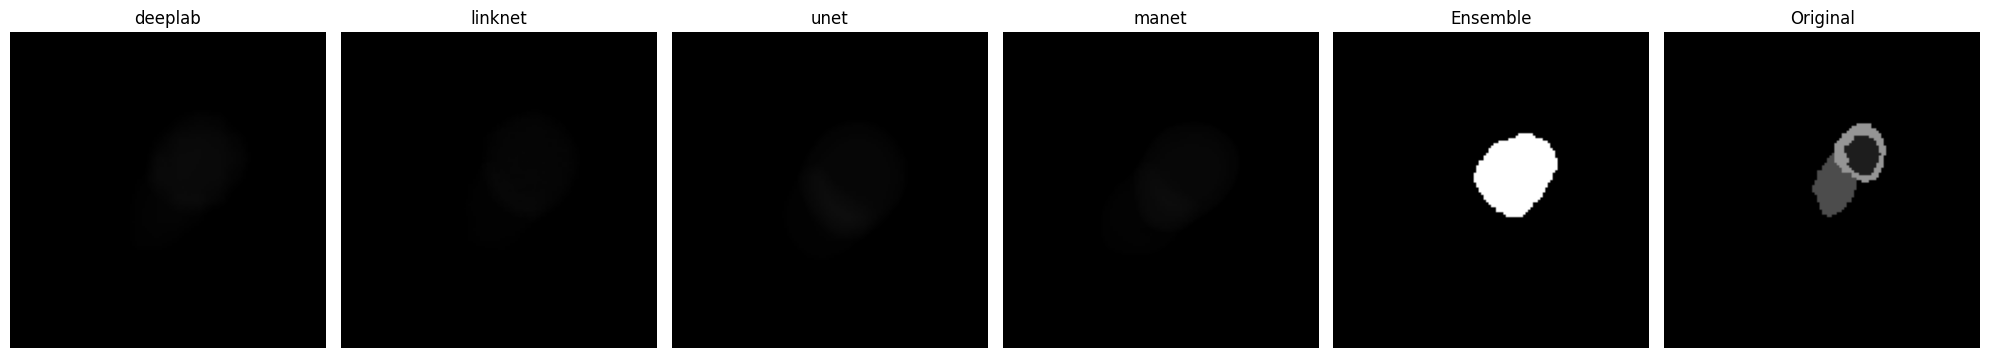

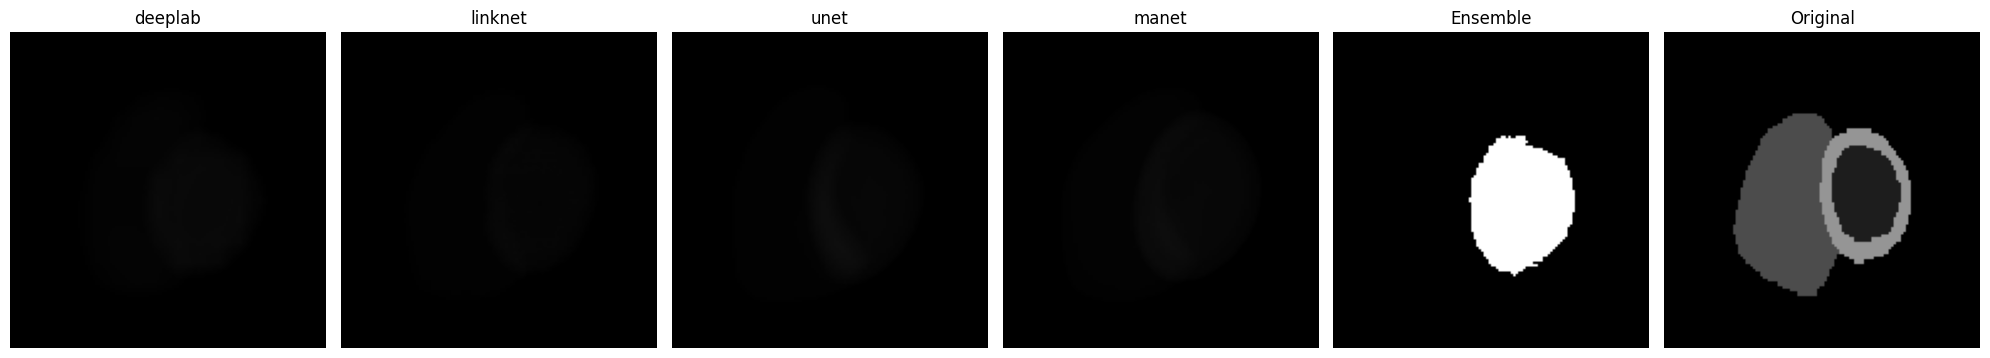

In [19]:
ensemble_model_with_thresholds(df.head(5), thresholds, method='vote')

## Evaluation

The actual ensemble outputs are not bad, but this would be really challagning to make a new ensemble model, because the models do not make the same predictions pixel by pixel.